In [1]:
# Importing necessary libraries

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error


In [2]:
# The following exercise will study the Accuracy Score of various Regression Models to predict a Team Change for any given Driver based on the factors WOE and IV defined as Strong Predictors.

# As always, let's deploy our Dataset first. 

data = pd.read_csv('/Users/alejandropalacios/Desktop/Ironhack/Data Analytics Bootcamp/Advanced Data Analysis Techniques/Project/F1-Grand-Prix-Predictor/Data Manipulation/Modeling/Modeled Databases/team_change_dataset.csv')

data.head()

,driver,season,round,circuit_id,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,nationality,...,driver_points,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,qualifying_time,driver_age,wins_percentage,change_teams
0,baldi,1983,1,jacarepagua,False,False,True,False,False,Italian,...,0,0,0,0,0,0,1.454,29,NaN,1
1,serra,1983,1,jacarepagua,False,False,True,False,False,Brazilian,...,0,0,0,0,0,0,5.293,26,0.0,1
2,surer,1983,1,jacarepagua,False,False,True,False,False,Swiss,...,0,0,0,0,0,0,3.796,31,NaN,1
3,manfred_winkelhock,1983,1,jacarepagua,False,False,True,False,False,German,...,0,0,0,0,0,0,6.481,31,NaN,1
4,patrese,1983,1,jacarepagua,False,False,True,False,False,Italian,...,0,0,0,0,0,0,1.286,28,NaN,1


In [3]:
# We must get dummies for the categorical variables dataset in order to properly run our Model.

df_woeiv = data[['season','constructor_standings_pos','constructor_wins','driver','qualifying_time','constructor','podium','change_teams']]

df_dum = pd.get_dummies(df_woeiv, columns = ['constructor','driver'] )

for col in df_dum.columns:
    if 'constructor' in col and df_dum[col].sum() < 140:
        df_dum.drop(col, axis = 1, inplace = True)
    
    elif 'driver' in col and df_dum[col].sum() < 140:
        df_dum.drop(col, axis = 1, inplace = True)
    else:
        pass

df_dum.to_csv('/Users/alejandropalacios/Desktop/Ironhack/Data Analytics Bootcamp/Advanced Data Analysis Techniques/Project/F1-Grand-Prix-Predictor/Data Manipulation/Modeling/Modeled Databases/team_change_dummies_dataset.csv', index = False)

In [4]:
# Now let's read our Dummified Data.

df = pd.read_csv('/Users/alejandropalacios/Desktop/Ironhack/Data Analytics Bootcamp/Advanced Data Analysis Techniques/Project/F1-Grand-Prix-Predictor/Data Manipulation/Modeling/Modeled Databases/team_change_dummies_dataset.csv')

# Setting the Season column as the index of the data frame.

df.set_index('season',inplace=True)

In [5]:
# A little check.

df.head()

,constructor_standings_pos,constructor_wins,qualifying_time,podium,change_teams,constructor_arrows,constructor_bar,constructor_benetton,constructor_brabham,constructor_ferrari,...,driver_prost,driver_raikkonen,driver_ralf_schumacher,driver_ricciardo,driver_rosberg,driver_senna,driver_trulli,driver_vettel,driver_villeneuve,driver_webber
season,,,,,,,,,,,,,,,,,,,,,
1983,0,0,1.454,21,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1983,0,0,5.293,8,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1983,0,0,3.796,5,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1983,0,0,6.481,14,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1983,0,0,1.286,23,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Check the quantity of null values in each columns
df.isnull().sum()

constructor_standings_pos    0
constructor_wins             0
qualifying_time              0
podium                       0
change_teams                 0
                            ..
driver_senna                 0
driver_trulli                0
driver_vettel                0
driver_villeneuve            0
driver_webber                0
Length: 66, dtype: int64

In [7]:
# Fill the null rows with the mean of respective columns
df = df.fillna(df.mean())

In [8]:
# Send our Dependent Variable to the end of the Dataset.
df = df[[c for c in df if c not in ['change_teams']] + ['change_teams']]

df.head()

,constructor_standings_pos,constructor_wins,qualifying_time,podium,constructor_arrows,constructor_bar,constructor_benetton,constructor_brabham,constructor_ferrari,constructor_footwork,...,driver_raikkonen,driver_ralf_schumacher,driver_ricciardo,driver_rosberg,driver_senna,driver_trulli,driver_vettel,driver_villeneuve,driver_webber,change_teams
season,,,,,,,,,,,,,,,,,,,,,
1983,0,0,1.454,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1983,0,0,5.293,8,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1983,0,0,3.796,5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1983,0,0,6.481,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1983,0,0,1.286,23,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
# Now for the FUNNN PARTTTT: Use of LSTMs in modelling Time Series data.

"""

Data Preparation.

So far we have loaded over data into our machines for modelling. Upon some inspection, we see that our data does not contain any NULL or NaN values.

As we are performing Time Series Analysis through machine learning modelling, we need to convert our data in the form of dependent (y) and independent 
variables (X). Here our dependent variable is change_teams and the rest of the variables construct the "independent" variable.

We will scale the data to process it faster and removing bias due to the range of data. Then we will need to divide the data into train and test data in 
the ratio 80:20. Note that since we are performing time series analysis, we cannot divide out data into train and test randomly, as we do while building other machine learning models, otherwise, the model will lode the most important essence, i.e. Time.

"""


# Scale the values
dataset = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df)

In [10]:
# Divide the data into train and test data
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [11]:
# Index the data into dependent and independent variables
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10976, 65) (10976,) (2744, 65) (2744,)


In [12]:
# Convert data into suitable dimension for using it as input in LSTM network
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10976, 1, 65) (10976,) (2744, 1, 65) (2744,)


Epoch 1/250
153/153 - 2s - loss: 0.0896 - val_loss: 0.0585
Epoch 2/250
153/153 - 2s - loss: 0.0867 - val_loss: 0.0569
Epoch 3/250
153/153 - 1s - loss: 0.0844 - val_loss: 0.0557
Epoch 4/250
153/153 - 2s - loss: 0.0829 - val_loss: 0.0548
Epoch 5/250
153/153 - 2s - loss: 0.0822 - val_loss: 0.0541
Epoch 6/250
153/153 - 2s - loss: 0.0819 - val_loss: 0.0541
Epoch 7/250
153/153 - 1s - loss: 0.0819 - val_loss: 0.0541
Epoch 8/250
153/153 - 2s - loss: 0.0819 - val_loss: 0.0544
Epoch 9/250
153/153 - 1s - loss: 0.0819 - val_loss: 0.0544
Epoch 10/250
153/153 - 1s - loss: 0.0819 - val_loss: 0.0541
Epoch 11/250
153/153 - 1s - loss: 0.0819 - val_loss: 0.0543
Epoch 12/250
153/153 - 1s - loss: 0.0819 - val_loss: 0.0541
Epoch 13/250
153/153 - 1s - loss: 0.0819 - val_loss: 0.0543
Epoch 14/250
153/153 - 1s - loss: 0.0819 - val_loss: 0.0543
Epoch 15/250
153/153 - 1s - loss: 0.0819 - val_loss: 0.0541
Epoch 16/250
153/153 - 1s - loss: 0.0819 - val_loss: 0.0541
Epoch 17/250
153/153 - 1s - loss: 0.0819 - val_lo

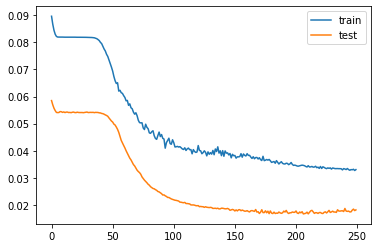

In [13]:
"""

Creating and fitting the model.

We will use the Keras API on the top of the Tensorflow library to build our model. 

- Hidden_nodes: The number of neurons in the hidden layer. We will take 250 neurons
- Dropout: It is used to reduce the overfitting of the model. Empirically it is set to 20%.
- Compile: The compile function will take parameters like loss and optimizer. Here we will take Mean Absolute Error as an error metric and Adam as an optimization algorithm.

"""

model = Sequential()
model.add(LSTM(250, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=250, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [14]:
"""

Predict and compare the values.

After fitting the model, we will check our model’s performance on the test data. As we normalized our data in the beginning before fitting the model,
we will have to reverse scale it to get back values in the original scale.

After we have our predicted values on the test data set and original test data, we will compare both by calculating the RMSE and plotting them together.

"""

# Prediction on training and testing data
train_predict = model.predict(train_X)    
test_predict = model.predict(test_X)  

In [15]:
# Converting from three dimension to two dimension
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_train_predict = concatenate((train_predict, train_X), axis=1)
inv_test_predict = concatenate((test_predict, test_X), axis=1)

In [16]:
# Transforming to original scale
inv_train_predict = scaler.inverse_transform(inv_train_predict)
inv_test_predict = scaler.inverse_transform(inv_test_predict)

In [17]:
# Predicted values on training data
inv_train_predict = inv_train_predict[:,0]
inv_train_predict

array([18.07862228, 18.90049279, 18.91465455, ..., 18.38273275,
       17.69702923, 19.21293044])

In [18]:
# Predicted values on testing data
inv_test_predict = inv_test_predict[:,0]
inv_test_predict 

array([1.77557261e+01, 1.87645682e+01, 1.76722980e+01, ...,
       8.34329752e-03, 3.16450257e-03, 3.51313062e-03])

In [19]:
# Scaling back the original train labels
train_y = train_y.reshape((len(train_y), 1))
inv_train_y = concatenate((train_y, train_X), axis=1)
inv_train_y = scaler.inverse_transform(inv_train_y)
inv_train_y = inv_train_y[:,0]

# Scaling back the original test labels
test_y = test_y.reshape((len(test_y), 1))
inv_test_y = concatenate((test_y, test_X), axis=1)
inv_test_y = scaler.inverse_transform(inv_test_y)
inv_test_y = inv_test_y[:,0]

Test RMSE: 3.136
Test RMSE: 2.542


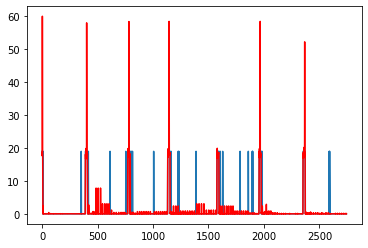

In [20]:
# Calculating rmse on train data
rmse_train = sqrt(mean_squared_error(inv_train_y, inv_train_predict))
print('Test RMSE: %.3f' % rmse_train)

# Calculating rmse on test data
rmse_test = sqrt(mean_squared_error(inv_test_y, inv_test_predict))
print('Test RMSE: %.3f' % rmse_test)

# Plotting the graph of test actual vs predicted
inv_test_y = inv_test_y.reshape(-1,1)
inv_test_y.shape

t = np.arange(0,2744,1)

plt.plot(t,inv_test_y,label="actual")
plt.plot(t,inv_test_predict,'r',label="predicted")
plt.show()

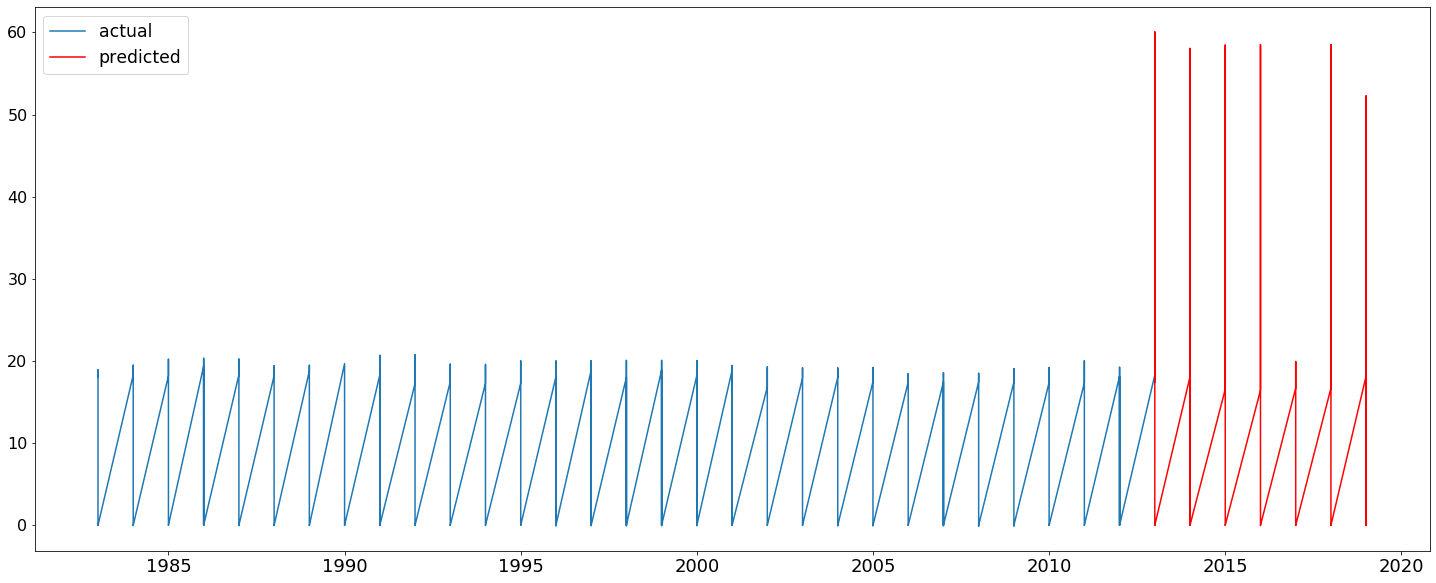

In [21]:
df_train = df.iloc[0:10976]
df_test = df.iloc[10976:]

# Plotting the graph to show multi step prediction
plt.figure(figsize=(25, 10))
plt.plot(df_train.index, inv_train_predict,label="actual")
plt.plot(df_test.index, inv_test_predict, color='r',label="predicted")
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()